In [2]:
import numpy as np
import math
import pandas as pd
from IPython.display import Image, display
from CoolProp.HumidAirProp import HAProps
import import_ipynb
from PsychrometricProperty import W_ptr, Tdp_ptr, h_ptr, v_ptr, W_ptb,RH_ptb,Tdp_ptb,h_ptb,v_ptb,Tdp_ptW,h_ptw,RH_ptw,W_pth,RH_pth,T_pwh

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Problem 1: Cooling Analysis of a CAV System
A Constant Air Volume (CAV) system with a Heat Recovery Ventilator (HRV) operates at design conditions for a commercial office building. The outdoor air conditions are 95°F dry-bulb temperature and 78°F wet-bulb temperature. The HRV has a sensible effectiveness of 0.85 and maintains balanced airflow between exhaust and supply.\ 
The building is treated as a single-zone system with a total cooling load of 500,000 Btu/hr and a sensible heat ratio (SHR) of 0.8. The design occupancy is 80 people, requiring a ventilation (outdoor) air flow rate of 1,600 CFM (based on 20 cfm per person). The thermostat is set to 77°F, maintaining comfort conditions, while the cooling coil temperature (equivalent to saturated supply air temperature) is 50°F. Complete the following:\
(a) calculate the required recirculated airflow rate in lbm/hr and ventilation (outdoor) airflow rate in lbm/hr (2 points); \
(b) calculate the cooling coil loads in Btu/hr, including total cooling load, sensible cooling load, and latent cooling load (2 points); \
(c) identify the thermodynamic conditions at key states in the system and mark them on the psychrometric chart, including the outdoor air (state 1), pre-cooled air (state2), mixed air (state 3), supply air (state 4), and return air (state 5) (3 points);\
(d) plot all processes on the psychrometric chart, including heat recovery process (HRV effect on outdoor air), mixing process, cooling and dehumidification process (2 points).


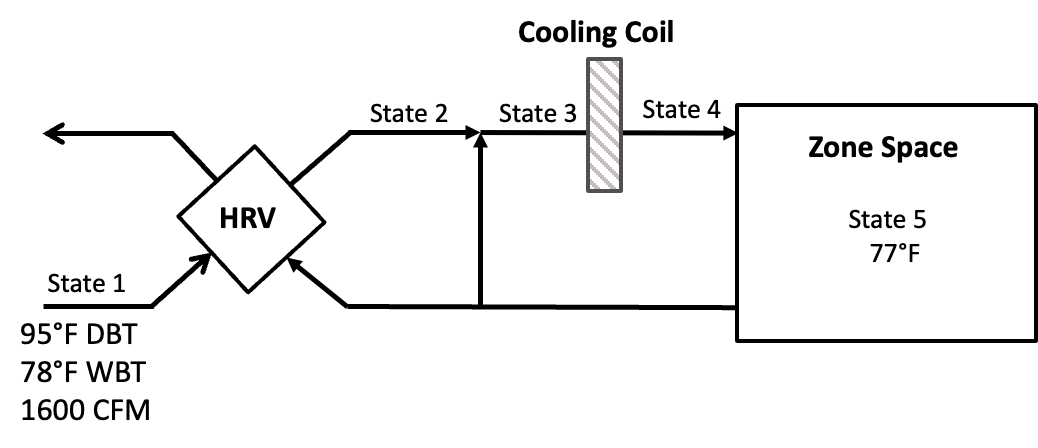

In [3]:
display(Image(filename='Midterm_P1.jpg')) 

The given information:

In [4]:

P_atm = 14.7 # standard atmosphere pressure, [psi]
V_dot_ven = 1600 # the ventilation volume flow rate [cfm]
T_db_1 = 95 # outdoor air drybulb temperature [F]
T_wb_1 = 78 # outdoor air wetbulb temperature [F]
RH_1 = RH_ptb(P_atm,T_db_1,T_wb_1) # outdoor air relative humidity [%]
h_1 = h_ptb(P_atm,T_db_1,T_wb_1) # outdoor air humidity ratio [Btu/lba]
w_1 = W_ptb(P_atm,T_db_1,T_wb_1) # outdoor air humidity ratio [lb_w/lb_a]
v_1 = v_ptb(P_atm,T_db_1,T_wb_1) # outdoor air specific volumn [ft3/lbm]

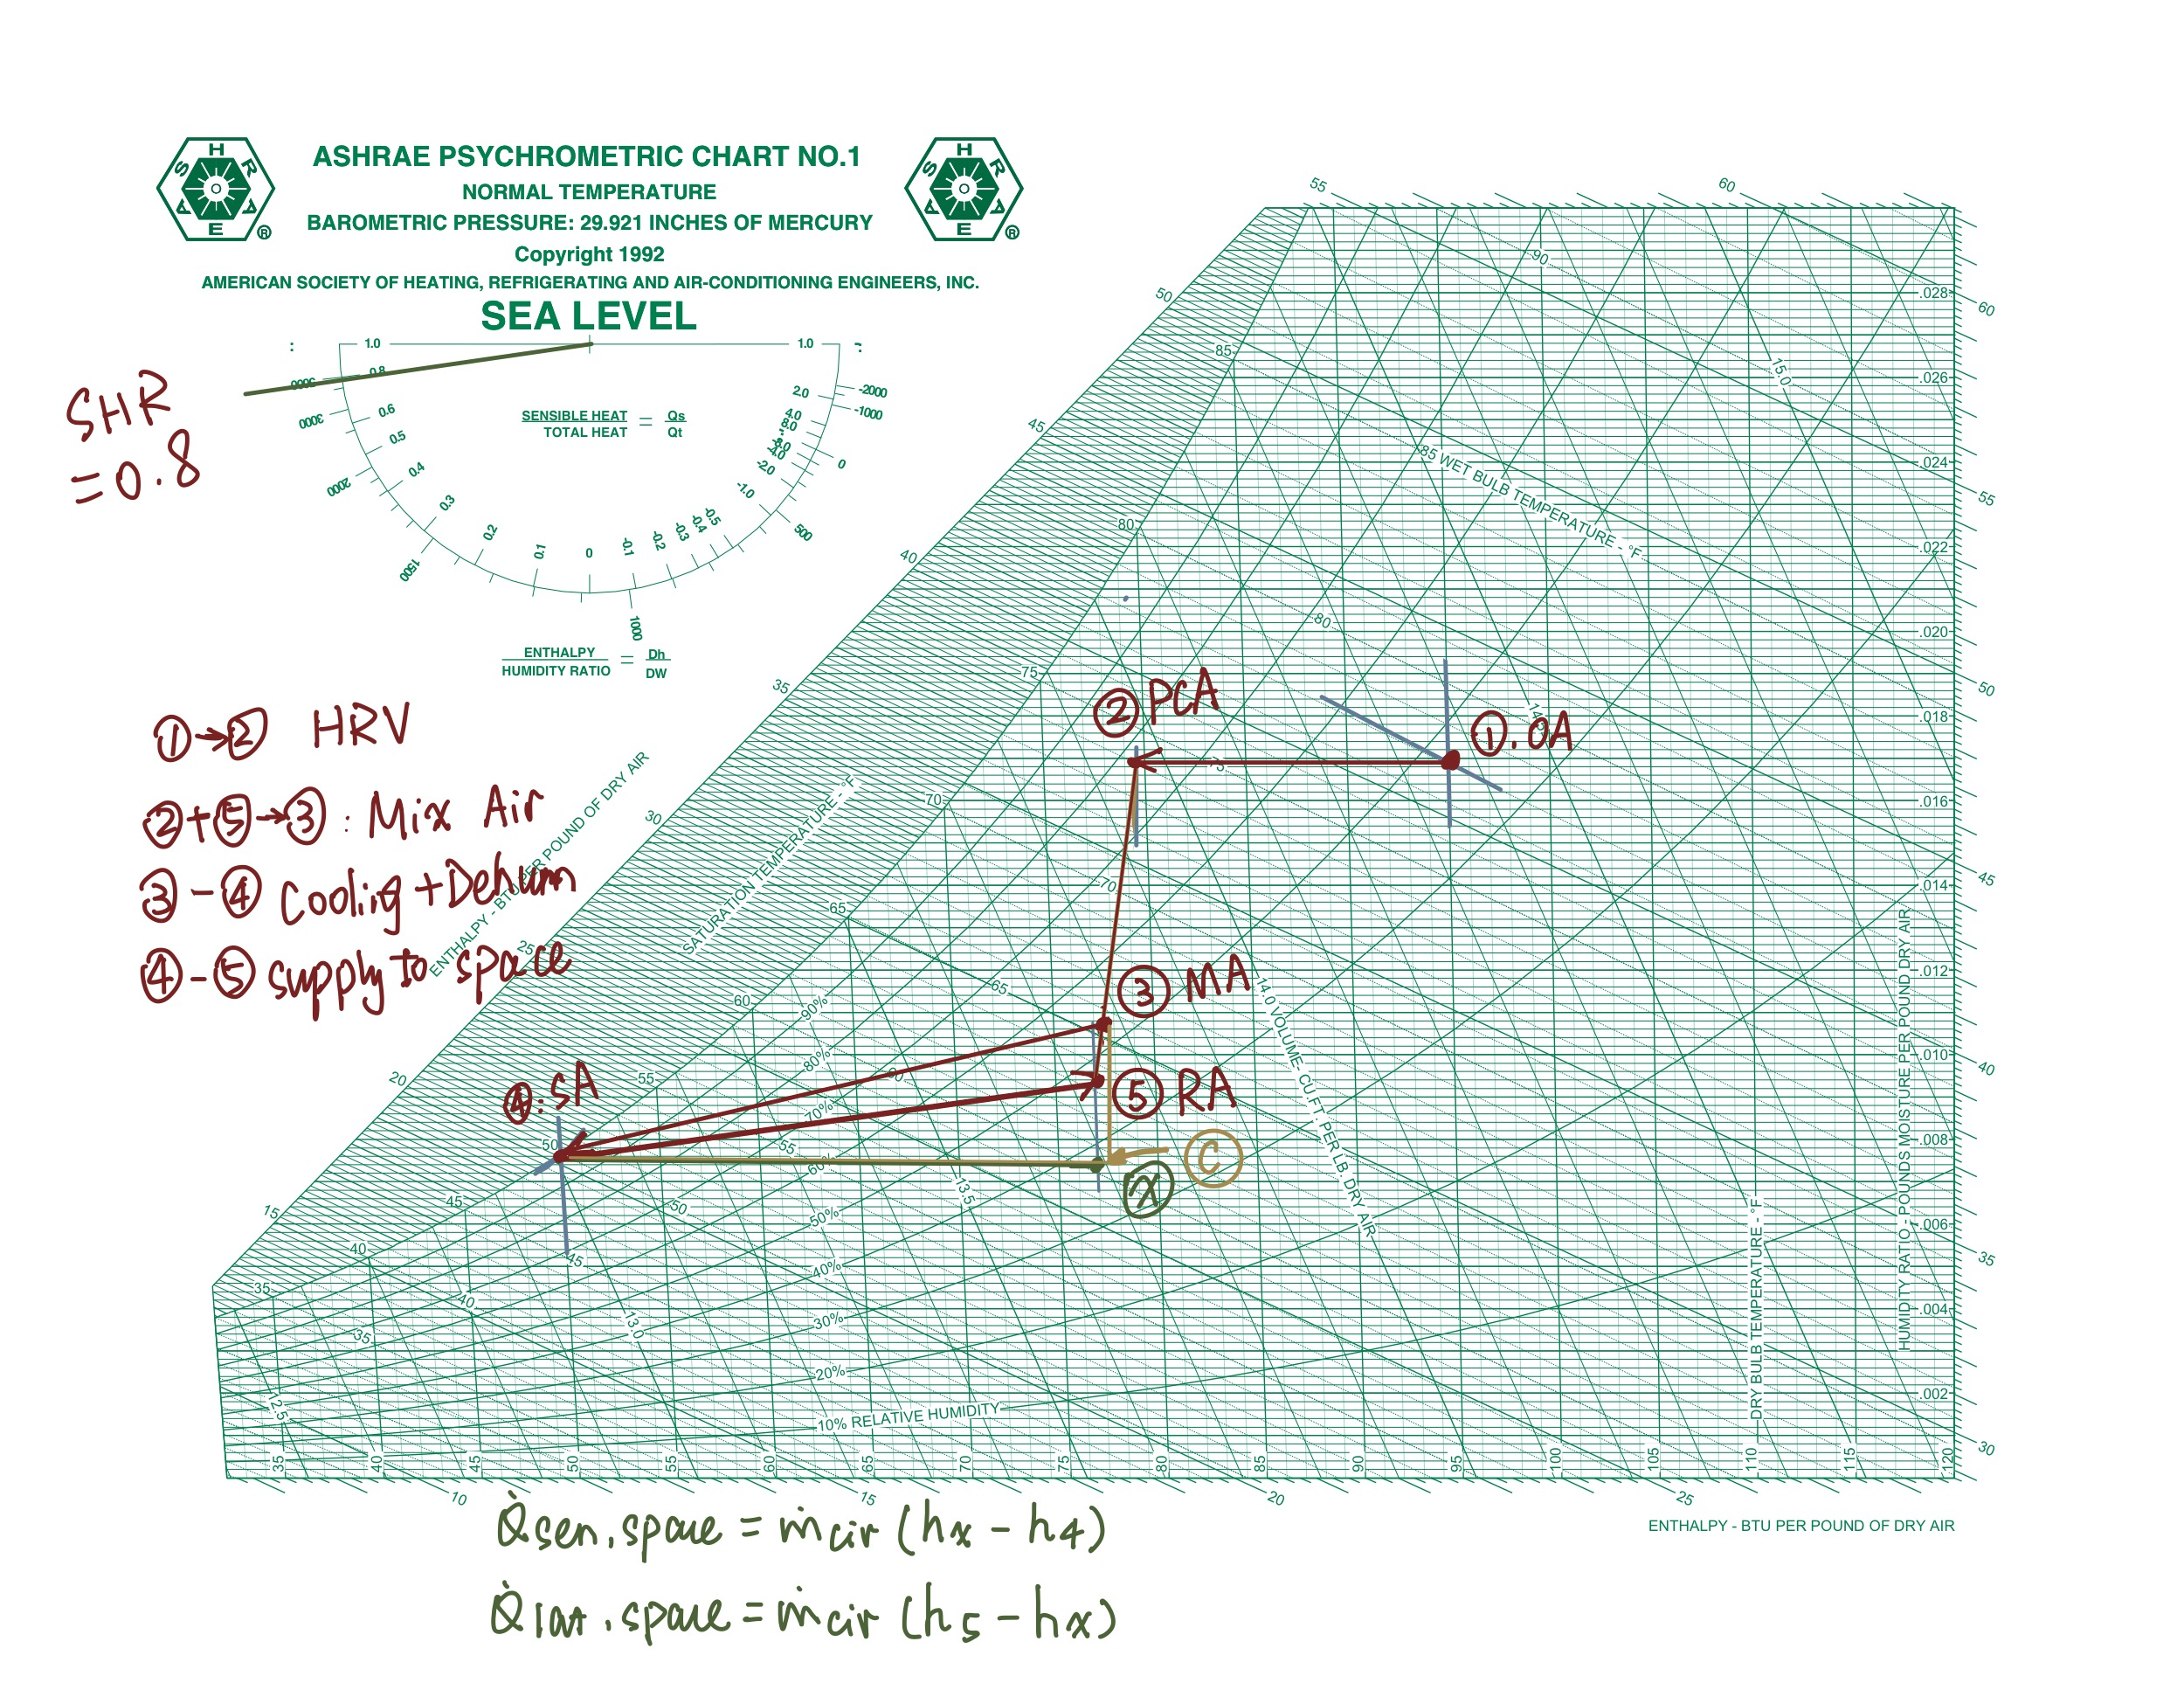

In [60]:
display(Image(filename='ASHRAE_PsychrometricChart.jpg')) 

#### Step 1: based on the energy balance for space:
We do not know the humidity of the space air, but we know its dry-bulb temperature. Thus, if we define a point where the temperature of point is equal to the space temperature and the humidity ratio of is equal to that of the supply air (state 4), we can determine the enthalpy of point $x$ as follows:
$$h_x = @(P_{atm}, T_{db,5}, w_4)$$
Based on the energy balance for space:
$$\dot{Q}_{sen,load} = \dot{m}_{SA} * (h_x - h_4)$$
where:
$$\dot{Q}_{sen,load} = \dot{Q}_{total,load} * SHR$$

Since the supply air out of cooling coil (state 4) is saturated and with $50F$ drybulb temperature, the supply air conditions can be determined:

In [23]:
T_db_4 = 50 #supply air drybulb temperature [F]
RH_4 = 100 #supply air relative humisity [%]
h_4 = h_ptr(P_atm,T_db_4,RH_4) #supply air enthalpy [Btu/lma]
v_4 = v_ptr(P_atm,T_db_4,RH_4) #supply air specific volumn []
w_4 = W_ptr(P_atm,T_db_4,RH_4) #supply air humidity ratio []

T_db_5 = 77 #return air drybulb temperature [F]
h_x = h_ptw(P_atm,T_db_5,w_4) #calculate the enthalpy of point x
print('enthalpy of point x is:',f"{h_x:.2f}",'[Btu/lba]') 

enthalpy of point x is: 26.83 [Btu/lba]


In [ ]:
Q_zone_sen = 500000 * 0.8 # the sensible load in space 
Q_zone_lat = 500000 * 0.2 # the latent load in space

# calculate the mass flow rate of supply air, [lbm/hr]
m_dot_SA = Q_zone_sen/(h_x - h_4)
# calculate the mass flow rate of ventilation (outdoor) air, [lbm/hr]
m_dot_ven = V_dot_ven * 60 / v_1 
# calculate the mass flow rate of recirculated (outdoor) air, [lbm/hr]
m_dot_cir = m_dot_SA - m_dot_ven

# Create and display results:
data = {
    "": ["Ventilation Air", "Re-circulated Air", "Supply Air"],
    "Mass flow rate [lbm/hr]": [f"{m_dot_ven:.2f}", f"{m_dot_cir:.2f}",f"{m_dot_SA:.2f}"]
}
df = pd.DataFrame(data)
df

,,Mass flow rate [lbm/hr]
0,Ventilation Air,4105.01
1,Re-circulated Air,56764.41
2,Supply Air,60869.43


After we obtained the total mass flow rate of supply air, we can calculate the humidity of space air based on the energy balance:
$$\dot{Q}_{lat,load} = \dot{m}_{SA} * (h_5 - h_x)$$
where:
$$\dot{Q}_{lat,load} = \dot{Q}_{total,load} * (1-SHR)$$
We will obtain the enthalpy of space air $h_5$

In [38]:
# Calculate the h_5
h_5 = Q_zone_lat/m_dot_SA + h_x # enthalpy of the space air
w_5 = W_pth(P_atm, T_db_5, h_5) # humidity ratio of space air
RH_5 = RH_pth(P_atm, T_db_5, h_5) # relative humisity of space 5

#### Step 2. To determine the pre-cooled air after HRV
The sensieble effectiveness is denfined as the ratio of actual recovered energy to maximum recovered energy:
$$\epsilon =  \frac{\dot{m}_{ven}c_p(T_1-T_2)}{\min(\dot{m}_{ven}c_p, \dot{m}_{ea}c_p)(T_1-T_5)}$$
For HRV run under balanced flow, the sensible effectiveness can be simplified as:
$$\epsilon =  \frac{(T_1-T_2)}{(T_1-T_5)}$$
The pre-cooled air temperature is:
$$T_2 = T_1 - \epsilon(T_1-T_5)$$
The humidity ratio (absolute humidity) of state 2 (pre-cooled air) remains the same as that of state 1 (outdoor air) since no moisture exchange occurs in the HRV:
$$w_2 = w_1$$

In [ ]:
epsilon = 0.85 # sensible effectiveness of the HRV,[-]
T_db_2 = T_db_1 - epsilon * (T_db_1 - T_db_5) # pre-cooled air drybulb temperature,[F]
w_2 = w_1 # humidity ratio of pre-cooled air
RH_2 = RH_ptw(P_atm, T_db_2, w_2) # relative humidity at state 2, [%]
h_2 = h_ptw(P_atm, T_db_2, w_2) # enthalpy at state 2, [Btu/lba]

#### Step 3. To determine the state 3 after mixing the return air and ventilation (outdoor air):
For the mixing point, based on the mass balance of the mositure:
$$\dot{m}_{ven} w_{2} + \dot{m}_{cir} w_{5} = \dot{m}_{SA} w_{3}$$
Based on the energy balance:
$$\dot{m}_{ven} h_{2} + \dot{m}_{cir} h_{5} = \dot{m}_{SA} h_{3}$$
Thus, the humidity ratio is:
$$w_{3} = \frac{\dot{m}_{ven} w_{2} + \dot{m}_{cir} w_{5}}{\dot{m}_{SA}}$$
the enthalpy is: 
$$h_{3} = \frac{\dot{m}_{ven} h_{2} + \dot{m}_{cir} h_{5}}{\dot{m}_{SA}}$$

In [41]:
w_3 = (m_dot_ven * w_2 + m_dot_cir * w_5)/m_dot_SA # humidity ratio at state 3, [lbw/lba]
h_3 = (m_dot_ven * h_2 + m_dot_cir * h_5)/m_dot_SA # enthalpy at state 3, [Btu/lba]
T_db_3 = T_pwh(P_atm, w_3, h_3) # dry-bulb at state 3, F
RH_3 = RH_ptw(P_atm, T_db_3, w_3) # relative humidity at state 3, %

In [53]:
# Create and display the results for all states
data = {
    "State": ["State 1", "State 2", "State 3","State 4","State 5"],
    "T_db [F]": [f"{T_db_1:.1f}",f"{T_db_2:.1f}",f"{T_db_3:.1f}",f"{T_db_4:.1f}",f"{T_db_5:.1f}"],
    "RH [%]": [f"{RH_1:.1f}",f"{RH_2:.1f}",f"{RH_3:.1f}",f"{RH_4:.1f}",f"{RH_5:.1f}"],
    "h [Btu/lba]": [f"{h_1:.2f}", f"{h_2:.2f}", f"{h_3:.2f}", f"{h_4:.2f}", f"{h_5:.2f}"],
    "w[lbw/lba]": [f"{w_1:.4f}", f"{w_2:.4f}", f"{w_3:.4f}", f"{w_4:.4f}", f"{w_5:.4f}"]
}
df = pd.DataFrame(data)
df

,State,T_db [F],RH [%],h [Btu/lba],w[lbw/lba]
0,State 1,95.0,47.3,41.29,0.0168
1,State 2,79.7,76.8,37.51,0.0168
2,State 3,77.2,48.5,29.09,0.0096
3,State 4,50.0,100.0,20.26,0.0076
4,State 5,77.0,46.3,28.48,0.0091


#### Step 4: Calculate the sensible and latent load for cooling coil:
To calculate the sensible and latent load for cooling coil, it is required to create a point, noted as $c$, in which 
$$h_c = @ (P = P_{atm}, T = T_{db,3}, w = w_4)$$
The sensible load for cooling coil:
$$\dot{Q}_{sen} = \dot{m}_{SA} (h_c - h_4)$$
The latent load for cooling coil:
$$\dot{Q}_{lat} = \dot{m}_{SA} (h_3 - h_c)$$

In [58]:
Q_coil_tot = m_dot_SA * (h_3-h_4) # total cooling load of cooling coil, [Btu/hr]
h_c = h_ptw(P_atm, T_db_3, w_4)
Q_coil_sen = m_dot_SA * (h_c-h_4) # sensible cooling load of cooling coil, [Btu/hr]
Q_coil_lat = m_dot_SA * (h_3-h_c) # latent cooling load of cooling coil, [Btu/hr]
SHR = Q_coil_sen/(Q_coil_sen + Q_coil_lat) # sensible heat ratio [-]

data = {
    "Sensible Cooling Load [Btu/hr]":[f"{Q_coil_sen:.1f}"],
    "Latent Cooling Load  [Btu/hr]":[f"{Q_coil_lat:.1f}"],
    "Total Cooling Load  [Btu/hr]":[f"{Q_coil_tot:.1f}"],
    "SHR [-]":[f"{SHR:.2f}"]
}
df = pd.DataFrame(data)
df

,Sensible Cooling Load [Btu/hr],Latent Cooling Load [Btu/hr],Total Cooling Load [Btu/hr],SHR [-]
0,402732.5,134343.6,537076.1,0.75


The SHR of the cooling coil is lower than that of the space load because the cooling coil handles both the sensible load of the space and the latent load from the ventilation (outdoor) air.

### Problem 2: Ductwork System Design and Analysis
A ductwork system is designed to distribute air throughout a building, with all duct sections having a roughness height of ε = 0.0003 ft. The following calculations and analyses are required:\
(a) determine the appropriate diameter for each straight duct section using the Equal Friction Method, ensuring that the maximum friction rate does not exceed 0.1 inH2O/100 ft of duct (2 points);\
(b) calculate the total pressure loss across the entire duct system (2 points);\
(c) identify the locations where the Butterfly Dampers should be installed at the ends of the ducts and determine the required damper settings (in degrees) for each installed damper to achieve balanced airflow distribution across the system (3 points);\
(d) calculate the minimum fan pressure required to overcome the system losses and determine the ideal power requirement for the fan (2 points).

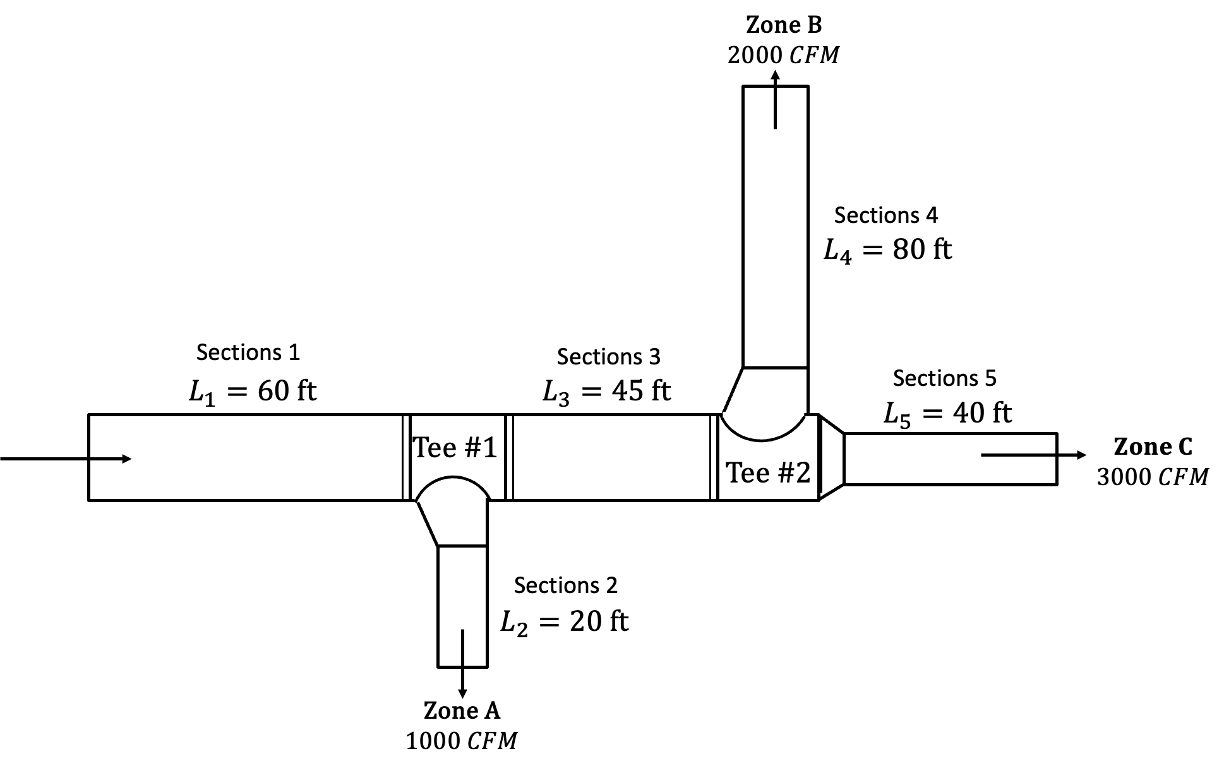

In [13]:
display(Image(filename='Midterm_P2.jpg')) 

In [14]:
C_tee_1_turn = 2.5
C_tee_1_str = 0.14
C_tee_2_turn = 0.58
C_tee_2_str = 0.14
C_diffuser = 0.1

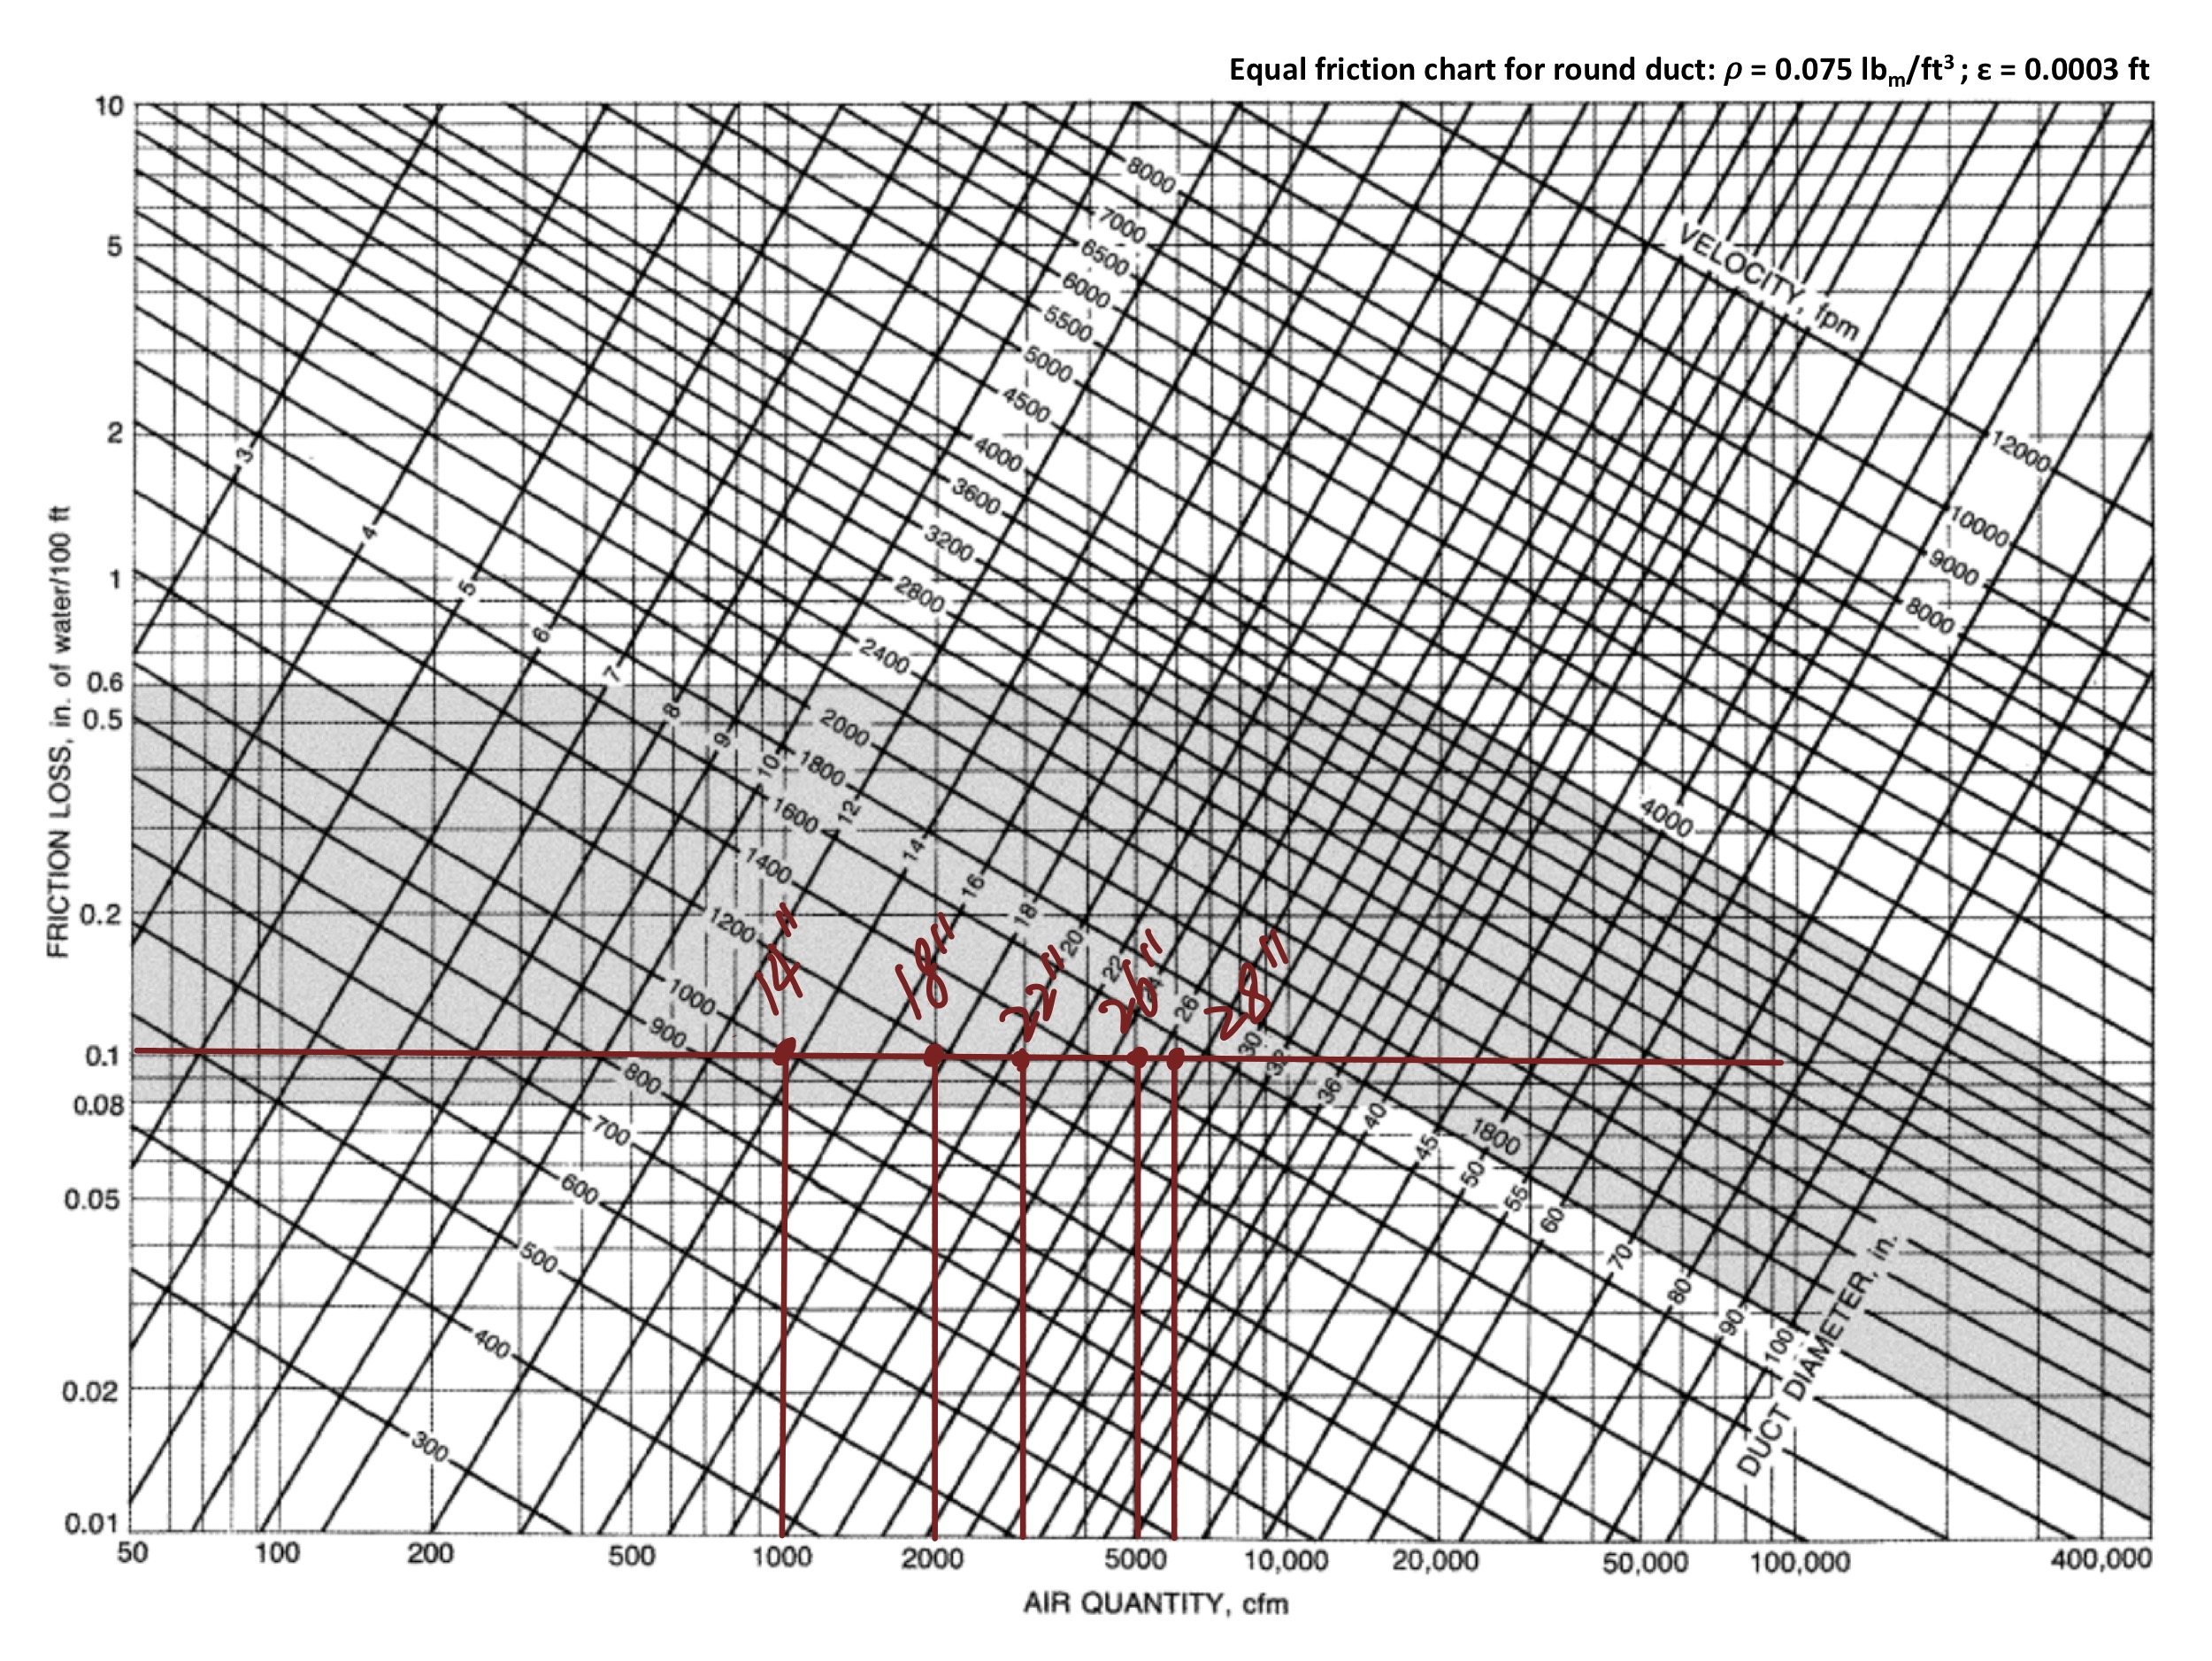

In [15]:
display(Image(filename='EqualFrictionChart.jpg')) 

In [ ]:
# a) determine the duct size:
D_1 = 28 # [in]
D_2 = 14 # [in]
D_3 = 26 # [in]
D_4 = 18 # [in]
D_5 = 22 # [in]

L_1 = 60 #[ft]
L_2 = 20 #[ft]
L_3 = 45 #[ft]
L_4 = 80 #[ft]
L_5 = 40 #[ft]

V_dot_1 = 6000 #[ft]
V_dot_2 = 1000 #[ft]
V_dot_3 = 5000 #[ft]
V_dot_4 = 2000 #[ft]
V_dot_5 = 3000 #[ft]
# calculte the speed for each section
A_1 = math.pi * (D_1/12)**2/4 #[ft2]
A_2 = math.pi * (D_2/12)**2/4 #[ft2]
A_3 = math.pi * (D_3/12)**2/4 #[ft2]
A_4 = math.pi * (D_4/12)**2/4 #[ft2]
A_5 = math.pi * (D_5/12)**2/4 #[ft2]
# calculate the velocity
v_1 =  V_dot_1/60/A_1 
v_2 =  V_dot_2/60/A_2
v_3 =  V_dot_3/60/A_3
v_4 =  V_dot_4/60/A_4
v_5 =  V_dot_5/60/A_5

In [17]:
# 2.1) major pressure drop for each sction:
f = 0.015
rho_air = 0.075
DP_1 = f * (L_1 / (D_1 / 12)) * (rho_air * v_1**2 / 2) * 0.005974451 # inH2O
DP_2 = f * (L_2 / (D_2 / 12)) * (rho_air * v_2**2 / 2) * 0.005974451 # inH2O
DP_3 = f * (L_3 / (D_3 / 12)) * (rho_air * v_3**2 / 2) * 0.005974451 # inH2O
DP_4 = f * (L_4 / (D_4 / 12)) * (rho_air * v_4**2 / 2) * 0.005974451 # inH2O
DP_5 = f * (L_5 / (D_5 / 12)) * (rho_air * v_5**2 / 2) * 0.005974451 # inH2O


In [18]:
data = {
    "Duct Segment": ["Section 1", "Section 2", "Section 3","Section 4","Section 5"],
    "L [ft]": [L_1, L_2, L_3, L_4, L_5],
    "V [CFM]": [V_dot_1, V_dot_2, V_dot_3, V_dot_4, V_dot_5],
    "D [in]": [D_1, D_2, D_3, D_4, D_5],
    "A [ft2]": [A_1, A_2, A_3, A_4, A_5],
    "v [ft/s]": [v_1, v_2, v_3, v_4, v_5],
    "DP [ft2]": [DP_1, DP_2, DP_3, DP_4, DP_5]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
df

,Duct Segment,L [ft],V [CFM],D [in],A [ft2],v [ft/s],DP [ft2]
0,Section 1,60,6000,28,4.276057,23.386032,0.047262
1,Section 2,20,1000,14,1.069014,15.590688,0.014003
2,Section 3,45,5000,26,3.687008,22.601885,0.035656
3,Section 4,80,2000,18,1.767146,18.862808,0.063772
4,Section 5,40,3000,22,2.639810,18.940754,0.026305


In [19]:
# 2.2) minor pressure drop for fittings:
DP_tee_1_turn = C_tee_1_turn * (rho_air * v_1**2 / 2) * 0.005974451
DP_tee_1_str = C_tee_1_str * (rho_air * v_1**2 / 2) * 0.005974451
DP_tee_2_turn = C_tee_2_turn * (rho_air * v_3**2 / 2) * 0.005974451
DP_tee_2_str = C_tee_2_str * (rho_air * v_3**2 / 2) * 0.005974451
DP_diffuser_2 = C_diffuser * (rho_air * v_2**2 / 2) * 0.005974451
DP_diffuser_5 = C_diffuser * (rho_air * v_4**2 / 2) * 0.005974451
DP_diffuser_6 = C_diffuser * (rho_air * v_5**2 / 2) * 0.005974451

# Calculate the pressure drop
DP_1_3 = DP_1 + DP_tee_1_turn + DP_2 #+ DP_diffuser_2
DP_1_5 = DP_1 + DP_tee_1_str + DP_3 + DP_tee_2_turn + DP_4 + DP_diffuser_5
DP_1_6 = DP_1 + DP_tee_1_str + DP_3 + DP_tee_2_str + DP_5 + DP_diffuser_6



In [20]:
data = {
    "DP [inH2O]": [DP_tee_1_str,DP_tee_1_turn,DP_tee_2_str,DP_tee_2_turn]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
df

,DP [inH2O]
0,0.017154
1,0.306325
2,0.016023
3,0.066381


In [21]:
data = {
    "DP [ft]": [DP_1_3, DP_1_5,DP_1_6]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
df

,DP [ft]
0,0.367590
1,0.238197
2,0.150437
